# Assignment 2 - Leonardo Stoppani

# Image Classification with Convolutional Neural Networks on CIFAR-10

## Define and train the model 

### Data preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

print(X_train.shape, X_val.shape, X_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
# one hot encode target values
train_labels = to_categorical(y_train, num_classes=10)
val_labels = to_categorical(y_val, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

# normalize pixel values
train_images = X_train.astype('float32') / 255
val_images = X_val.astype('float32') / 255
test_images = X_test.astype('float32') / 255

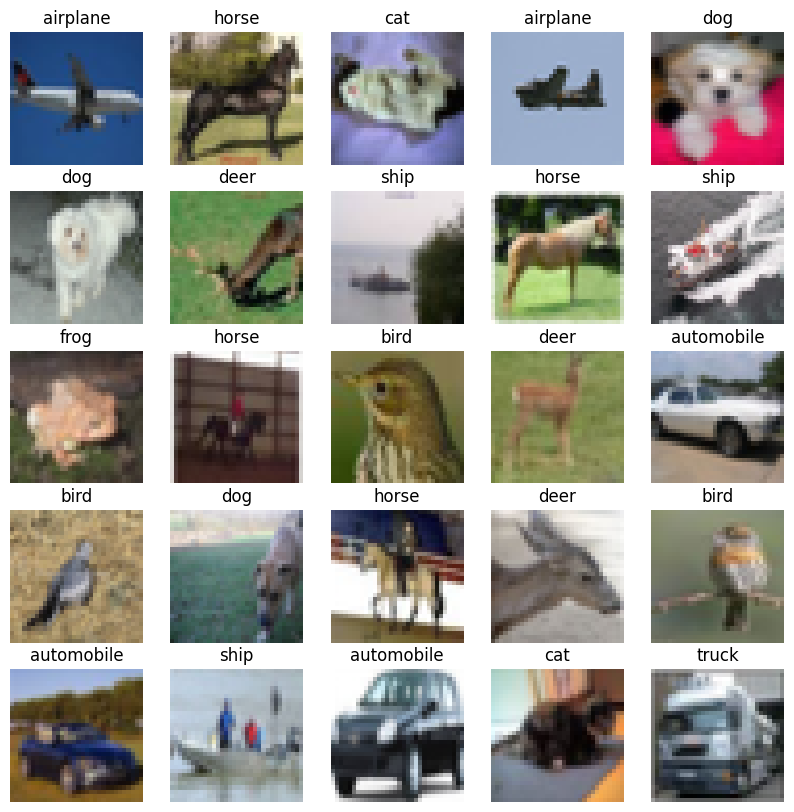

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                'horse', 'ship', 'truck']

fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(train_images[i])
    # show labels from one hot to categorical
    ax.set_title(class_names[np.argmax(train_labels[i])])
    ax.axis('off')
plt.show()


### Data augmentation
To achieve better results, we can augment the data by applying random transformations to the images. This will allow the model to generalize better, and to be more robust to different transformations of the input images, working as regularization.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_images)

### Define the CNN architecture

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)         

### Train the model

In [8]:
#adam = tf.keras.optimizers.legacy.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# model.compile(optimizer=adam,
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['accuracy'])

/Users/lilf4p/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
# train on gpu 
#tf.device('/device:GPU:0')

# early stopping when validation loss does not improve or overfitting occurs in 10 epochs
#early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True, mode='min')

# tensorboard callback
#! rm -rf ./logs/
#from datetime import datetime
#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# train model with data augmentation
#history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=100,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100


2023-05-08 16:03:48.624398: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 13s 39ms/step - loss: 1.7537 - accuracy: 0.3585 - val_loss: 1.4321 - val_accuracy: 0.4889
Epoch 2/100
313/313 [==============================] - 12s 38ms/step - loss: 1.4130 - accuracy: 0.4882 - val_loss: 1.2801 - val_accuracy: 0.5427
Epoch 3/100
313/313 [==============================] - 12s 38ms/step - loss: 1.2775 - accuracy: 0.5425 - val_loss: 1.1249 - val_accuracy: 0.6005
Epoch 4/100
313/313 [==============================] - 12s 38ms/step - loss: 1.1980 - accuracy: 0.5713 - val_loss: 1.0793 - val_accuracy: 0.6235
Epoch 5/100
313/313 [==============================] - 12s 38ms/step - loss: 1.1232 - accuracy: 0.5991 - val_loss: 0.9751 - val_accuracy: 0.6598
Epoch 6/100
313/313 [==============================] - 12s 38ms/step - loss: 1.0619 - accuracy: 0.6212 - val_loss: 0.9143 - val_accuracy: 0.6785
Epoch 7/100
313/313 [==============================] - 12s 38ms/step - loss: 1.0226 - accuracy: 0.6373 - val_loss: 1.0042 - val_accuracy: 0.64

In [12]:
# continue training with early stopping for 100 more epochs
#early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True, mode='min')

# history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=50,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/50
313/313 [==============================] - 12s 39ms/step - loss: 0.5177 - accuracy: 0.8187 - val_loss: 0.5296 - val_accuracy: 0.8239
Epoch 2/50
313/313 [==============================] - 12s 39ms/step - loss: 0.5179 - accuracy: 0.8187 - val_loss: 0.5927 - val_accuracy: 0.8117
Epoch 3/50
313/313 [==============================] - 13s 40ms/step - loss: 0.5159 - accuracy: 0.8188 - val_loss: 0.5259 - val_accuracy: 0.8241
Epoch 4/50
313/313 [==============================] - 12s 39ms/step - loss: 0.5166 - accuracy: 0.8191 - val_loss: 0.5488 - val_accuracy: 0.8195
Epoch 5/50
313/313 [==============================] - 13s 40ms/step - loss: 0.5181 - accuracy: 0.8166 - val_loss: 0.5653 - val_accuracy: 0.8136
Epoch 6/50
313/313 [==============================] - 12s 39ms/step - loss: 0.5085 - accuracy: 0.8182 - val_loss: 0.5563 - val_accuracy: 0.8151
Epoch 7/50
313/313 [==============================] - 12s 39ms/step - loss: 0.5081 - accuracy: 0.8206 - val_loss: 0.5291 - val_accuracy:

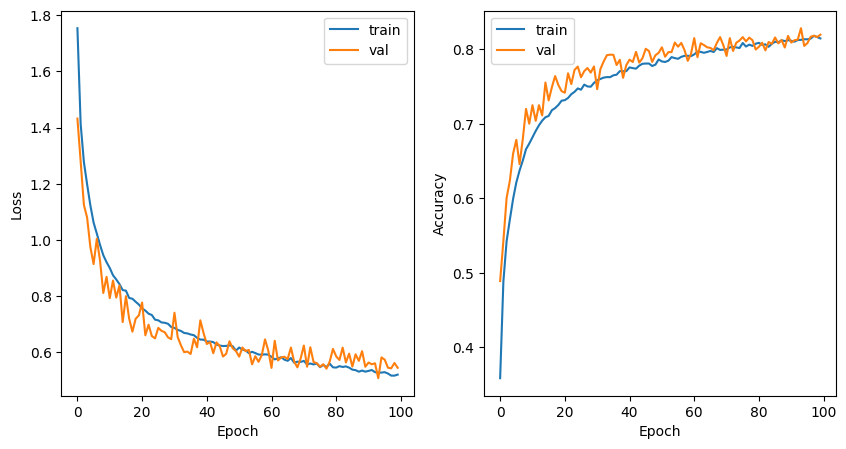

In [10]:
# plot loss and accuracy of validation and training data in subplots
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# save the model with unique name based on number of parameters and validation accuracy
#model.save(f'cifar10_model_{model.count_params()}_{round(history.history["val_accuracy"][-1], 2)}.h5')

### Evaluate model on test set
Evaluating the model on test images shows an accuracy of 83%.

In [9]:
model = models.load_model('cifar10_model_620362_0.83.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {round(test_acc, 2)}')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-09 11:43:14.335532: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 - 3s - loss: 0.5198 - accuracy: 0.8323 - 3s/epoch - 8ms/step
Test accuracy: 0.83


Confusion matrix shows that the model is able to classify most of the images correctly. However, it is not able to classify images of cats and dogs correctly. This is because the model is not able to learn the features of cats and dogs properly. This can be improved by increasing the number of convolutional layers and increasing the number of filters in each layer. Also, the model can be trained for more epochs to improve the accuracy.

313/313 [==============================] - 1s 4ms/step


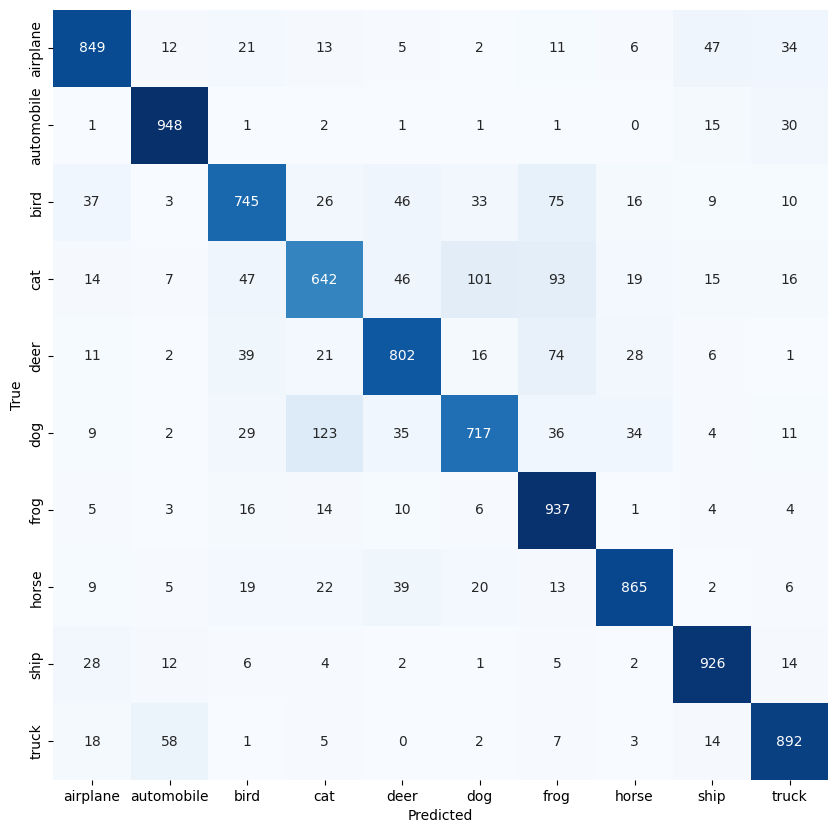

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


We can see how the model cannot decide between cat and dog for the above image.

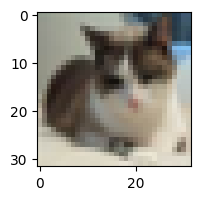

1/1 [==============================] - 0s 15ms/step
cat: 0.8310598134994507
dog: 0.16566582024097443
frog: 0.0021836585365235806
deer: 0.0005938632530160248
bird: 0.000213820138014853


In [71]:
# make a prediction on a random image
#random_image = np.random.randint(0, len(test_images))
random_image = 3129 #gatto
plt.figure(figsize=(2, 2))
plt.imshow(test_images[random_image])
plt.show()

# predict class of random image
prediction = model.predict(test_images[random_image].reshape(1, 32, 32, 3))

# ptint the first 5 class labels with highest probability
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

## Test with occlusions

Now that we have the final model, we can test it with occluded images. First we define a function `patch_image` that take an image as input and return the same image with a gray patch of nxn size. Function allow also to specify the position of the patch. After we can start to study the behavior of the model on test images with different occlusions in size and position.

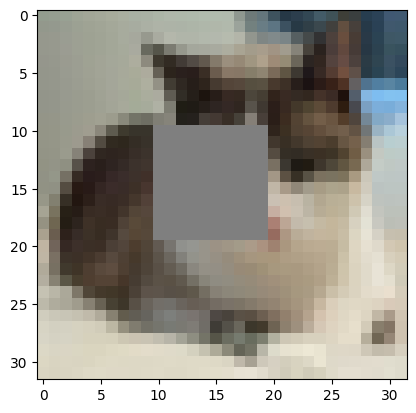

In [12]:
def patch_image(image, x=0, y=0, n=1):
    im = image.copy()
    im[x:x+n, y:y+n] = 0.5
    return im

patch_image1 = patch_image(test_images[random_image], 10, 10, 10)

plt.imshow(patch_image1)
plt.show()

In [162]:
prediction = model.predict(patch_image1.reshape(1, 32, 32, 3))
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 14ms/step
cat: 0.669676661491394
dog: 0.29367831349372864
bird: 0.009415562264621258
truck: 0.008858528919517994
frog: 0.006101746577769518


As the confusion matrix shows, the model has a hard time classifying images of cats and dogs. A patch of size 10x10 applied in the center of the image is enough to cause a significant drop in accuracy. 

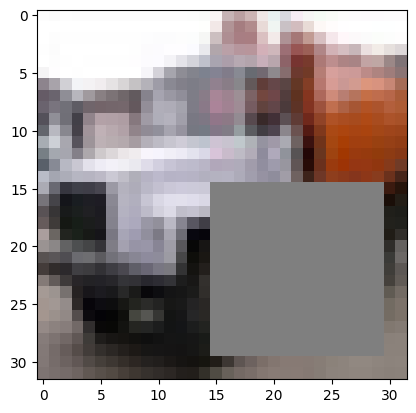

In [150]:
patch_image2 = patch_image(test_images[3409], 15, 15, 15)

plt.imshow(patch_image2)
plt.show()

In [151]:
prediction = model.predict(patch_image2.reshape(1, 32, 32, 3))
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 14ms/step
automobile: 0.6405659317970276
truck: 0.3130090832710266
airplane: 0.04376723989844322
ship: 0.0021947561763226986
horse: 0.00020000821677967906


A patch of size 15x15 in the bottom right corner of the image change the classification of the image from `truck` to `car`.

### Accuracy on occluded images

We can now check how much the accuracy on test set drops when we occlude part of the image. 

In [25]:
patched_images = []
for i in range(len(test_images)):
    patched_images.append(patch_image(test_images[i], 10, 10, 10))

patched_images = np.array(patched_images)

# compute the accuracy of the patched images
test_loss, test_acc = model.evaluate(patched_images, test_labels, verbose=2)

print(f'Test accuracy: {round(test_acc, 2)}')

313/313 - 2s - loss: 0.9288 - accuracy: 0.6988 - 2s/epoch - 8ms/step
Test accuracy: 0.7


### Find main pixels

By sliding a pacth of 1x1 over all the image we can also check which pixel is more important for the classification. We can see that the pixels in the center of the image are more important for the classification, while the pixels in the corners are less important.

In [58]:
def find_main_pixel(image, size):

    pix_prob = {}
    for j in range(32):
        for k in range(32):

            pp = patch_image(image, j, k, size)
            pp = pp.reshape(1, 32, 32, 3)

            prediction = model.predict(pp, verbose=0)
            prediction_prob = prediction[0][np.argsort(prediction[0])[-1]]
            prediction_name = class_names[np.argmax(prediction)]

            pix_prob[(j, k)] = (prediction_prob, prediction_name)
    
    return pix_prob

In the cat image the pixel with coordinates (14, 5) is the one that drop the most the prediction of the model. With only this pixel occluded the model turns from predict the class `cat` with 83% probability to 72%.

((14, 5), (0.72262454, 'cat'))


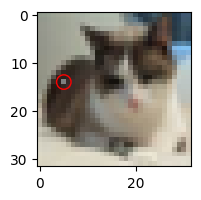

In [68]:
pix_prob = find_main_pixel(test_images[3129],1)

# pixel with lowest probability
main_pixel = min(pix_prob.items(), key=lambda x: x[1][0])

# show the image with lowest probability
x,y = main_pixel[0]
plt.figure(figsize=(2,2))

# draw a red circle around the pixel with lowest probability
circle = plt.Circle((y, x), 1.5, color='r', fill=False)
plt.gca().add_patch(circle)

plt.imshow(patch_image(test_images[3129], x, y, 1))
print(main_pixel)

In the truck image a single image cannot change the prediction, so we check with a patch of 10x10.

((16, 16), (0.86493754, 'truck'))


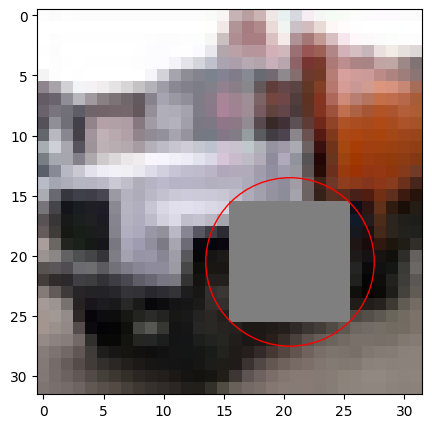

In [67]:
pix_prob_truck = find_main_pixel(test_images[3409], 10)

# pixel with lowest probability
main_pixel_truck = min(pix_prob_truck.items(), key=lambda x: x[1][0])

# show the image with lowest probability
x,y = main_pixel_truck[0]
plt.figure(figsize=(2,2))

# draw a red circle around the pixel with lowest probability
circle = plt.Circle((y+4.5, x+4.5), 7, color='r', fill=False)
plt.gca().add_patch(circle)

plt.imshow(patch_image(test_images[3409], x, y, 10))
print(main_pixel_truck)

## Final Considerations